In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from ipynb.fs.full.util import get_df_splits
from ipynb.fs.full.util import get_feature_importances
from ipynb.fs.full.util import get_feature_weights
from ipynb.fs.full.util import run_classifier_cv
from ipynb.fs.full.util import to_X_y
from ipynb.fs.full.util import to_X_y_tt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 10000)
pd.set_option("display.max_rows", None)

In [3]:
df = pd.read_csv("../data/dataset_cleaned.csv", na_values=["_NULL_"], keep_default_na=False)

In [4]:
df = df[
    (df["test_outcome"] == "positive") | (df["test_outcome"] == "negative")
]
display(df.shape)

(34517, 14)

In [5]:
df_splits = get_df_splits(df)

X_y_splits = []
for df_train, df_test in df_splits:
    vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5)
    X_train, X_test, y_train, y_test, _ = to_X_y_tt(vectorizer, df_train, df_test, "test_outcome")
    
    X_y_splits.append((X_train, X_test, y_train, y_test, df_test))

In [6]:
classifier_factories = [
    MultinomialNB,
    lambda: LogisticRegression(solver="lbfgs", max_iter=1000),
    lambda: RandomForestClassifier(n_estimators=100, random_state=1731),
    lambda: LinearSVC(random_state=1731, max_iter=10000)
]

accuracies = []
errors = []
for index, classifier_factory in enumerate(classifier_factories):
    accuracy, confusion, precision, recall, error = run_classifier_cv(classifier_factory, X_y_splits, ["positive", "negative"])
    accuracies.append(accuracy)
    errors.append(error)
    
    display(f"Classifier {index + 1}")
    display(accuracy)
    display(confusion)
    display(precision)
    display(recall)

'Classifier 1'

0.9560796236341732

array([[17947,  1302],
       [  214, 15054]])

array([0.98821651, 0.92039618])

array([0.93236012, 0.98598376])

'Classifier 2'

0.9959730088635954

array([[19173,    76],
       [   63, 15205]])

array([0.99672489, 0.9950265 ])

array([0.99605174, 0.99587372])

'Classifier 3'

0.995654311046518

array([[19164,    85],
       [   65, 15203]])

array([0.99661969, 0.99444008])

array([0.99558419, 0.99574273])

'Classifier 4'

0.9957122904394936

array([[19168,    81],
       [   67, 15201]])

array([0.99651677, 0.99469965])

array([0.99579199, 0.99561174])

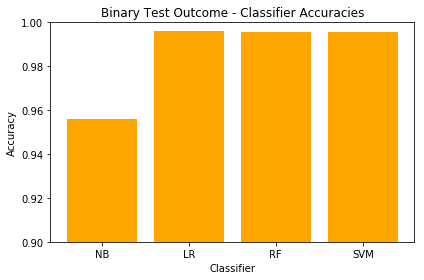

In [7]:
X = ["NB", "LR", "RF", "SVM"]
n = len(X)

plt.bar(range(n), accuracies, align="center", color="orange")

plt.xticks(range(n), X)
plt.ylim(0.9, 1)

plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Binary Test Outcome - Classifier Accuracies")

plt.tight_layout()
plt.savefig("../figs/bto_accuracies.png")

In [ ]:
errors[3]

In [9]:
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5)
X, y, feature_names = to_X_y(vectorizer, df, "test_outcome")

classifier = LogisticRegression(solver="lbfgs", max_iter=1000)
classifier.fit(X, y)

min_weights, max_weights = get_feature_weights(classifier, feature_names)

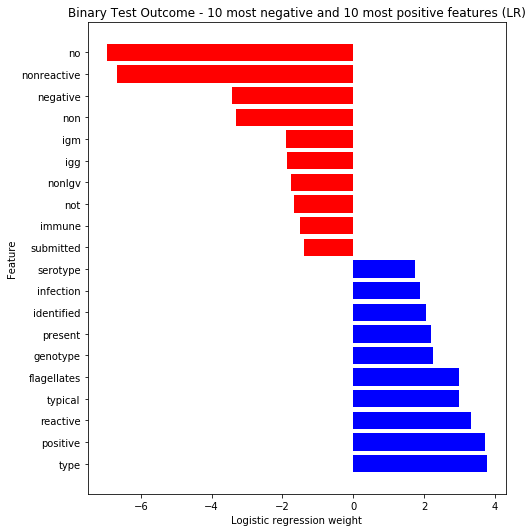

In [10]:
plt.figure(figsize=(7.5, 7.5))

m = len(min_weights)
n = len(max_weights)

y = [-x for x in range(m + n)]
width = [x[1] for x in min_weights + max_weights]

plt.barh(y[:m], width[:m], color="red")
plt.barh(y[m:], width[m:], color="blue")

feature_names = [x[0] for x in min_weights + max_weights]
plt.yticks(y, feature_names)

plt.xlabel("Logistic regression weight")
plt.ylabel("Feature")
plt.title("Binary Test Outcome - 10 most negative and 10 most positive features (LR)")

plt.tight_layout()
plt.savefig("../figs/bto_lr_features.png")

In [11]:
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5)
X, y, feature_names = to_X_y(vectorizer, df, "test_outcome")

classifier = RandomForestClassifier(n_estimators=100, random_state=1731)
classifier.fit(X, y)

feature_importances = get_feature_importances(classifier, feature_names)

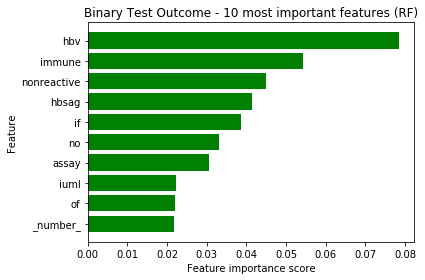

In [12]:
y = [-x for x in range(len(feature_importances))]
width = [x[1] for x in feature_importances]

plt.barh(y, width, color="green")

feature_names = [x[0] for x in feature_importances]
plt.yticks(y, feature_names)

plt.xlabel("Feature importance score")
plt.ylabel("Feature")
plt.title("Binary Test Outcome - 10 most important features (RF)")

plt.tight_layout()
plt.savefig("../figs/bto_rf_features.png")